# Searching for exotic particles in high-energy physics with deep learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline


# Clasificación

[Searching for exotic particles in high-energy physics with deep learning](https://www.nature.com/articles/ncomms5308.pdf)

Las colisiones de alta energía en aceleradores de partículas son fuente para la búsqueda y descubrimiento de nuevas partículas exóticas. Sin embargo, encontrar estar partículas exóticas requiere resolver el difícil problema de discriminar la señal en contra del ruido. 

Este problema en específico busca distinguir procesos en colisionadores de hadrónes en los cuales se producen partículas supersiméticas (SUSY) en contra de procesos en los cuales estas partículas no son producidas.

Este dataset contiene en la primera columna la clase objetivo (1 para procesos SUSY y 0 en caso contrario). Las demás columnas son caraterísticas usadas opara la tarea predictiva, divididas en dos tipos:
- Las primeras ocho columnas corresponden a propiedades cinemáticas de las colisiones medidas por los detectores en el acelerador. Estas son llamadas características de bajo nivel.
- Las demás diez columnas corresponden a características de alto nivel que son derivadas por los científicos para ayudar a la discriminación de las dos clases.



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
!wget -O susy_dataset.csv.gz https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

--2021-10-11 16:14:54--  https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 922377711 (880M) [application/x-httpd-php]
Saving to: ‘susy_dataset.csv.gz’

susy_dataset.csv.gz 100%[===================>] 879.65M  19.5MB/s    in 46s     

2021-10-11 16:15:40 (19.2 MB/s) - ‘susy_dataset.csv.gz’ saved [922377711/922377711]



In [ ]:
column_names = ["class", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]
susy_data = pd.read_csv("susy_dataset.csv.gz", compression="gzip", names=column_names)

In [ ]:
susy_data.head()

,class,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [ ]:
# Dataset dimensions 
susy_data.shape

(5000000, 19)

In [ ]:
# Number of instances in each class
susy_data['class'].value_counts()

0.0    2712173
1.0    2287827
Name: class, dtype: int64

In [ ]:
# Features 
X_susy_all = susy_data.drop('class', axis=1) 

# Target
y_susy = susy_data['class']

X_susy_all.head()

,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


Se crean las siguientes funciones:

In [ ]:
def heatmap_confusion_matrix(y_test, y_pred, labels):
    
    '''Creates the confusion matrix and the classification report'''
    
    confusion = confusion_matrix(y_test, y_pred)
 
    sns.heatmap(confusion.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues",
            xticklabels=labels, yticklabels=labels)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()
    
    print(classification_report(y_test, y_pred, target_names=labels))
    
    return confusion

In [ ]:
def modelGridSearch(model, params, X_train, X_test, y_train, y_test, name):

  ''' Does the GridsearchCV for a given model,
  creates the ROC Curve and calculates the scores '''

  # -------- Grid Search --------
  classification =  GridSearchCV(model, params, scoring="r2",verbose=0)
  classification.fit(X_train, y_train)

  # Best parameters of the Grid Search
  print('Best parameters: ',classification.best_params_)


  # -------- Predictions --------
  y_pred = classification.predict(X_test)

  # Predict probabilities (to make the ROC Curve)
  y_probs = classification.predict_proba(X_test)

  # keep probabilities for the positive outcome only
  y_probs = y_probs[:, 1]

  # -------- calculate scores --------
  auc = roc_auc_score(y_test, y_probs)


  # -------- ROC curve --------
  r = random.random()
  b = random.random()
  g = random.random()
    
  color = (r, 0.5, b)

  # False positives and true positives rate
  fpr, tpr, _ = roc_curve(y_test, y_probs)
  plt.plot(fpr, tpr, marker='.', label=name, color=color, alpha=0.5)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
    
  return y_probs, y_pred, auc, classification.best_estimator_, 


In [ ]:
def datasets(data, X, y):

  '''Selects the columns of the dataset and 
  divides the data into train and test'''

  # -------- Choose the dataset --------
  if data == 'LOW':
     X = X.iloc[:,0:8]
  if data == 'HIGH':
     X = X.iloc[:,8:19]

  # -------- Splits in train and test --------
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  return X_train, X_test, y_train, y_test
  

In [ ]:
def modelClassification(data, X, y):

  '''Applies 3 different classification algorithms'''

  X_train, X_test, y_train, y_test = datasets(data, X, y)

  # -------- Models Parameters  --------
  logistic_params = [{'C': [0.001, 0.01, 0.1, 1.0]}]
  tree_param = {'criterion':['gini','entropy'],
                'max_depth':[3, 6,9]}
  sgd_params = {
    "loss" : ["log"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1"],
    }

  # -------- Classification Modeles  --------
  plt.figure(figsize=(8,5))

  y_prob_log, y_pred_log, auc_log, estimator_log = modelGridSearch(LogisticRegression(),
                                                       logistic_params,
                                                       X_train, X_test, y_train, y_test,
                                                       'logistic')
  

  y_prob_tree, y_pred_tree, auc_tree, estimator_tree = modelGridSearch(DecisionTreeClassifier(), 
                                                          tree_param,
                                                          X_train, X_test, y_train, y_test,
                                                          'tree')
  
  y_prob_svc, y_pred_svc, auc_svc, estimator_svc =  modelGridSearch(SGDClassifier(), 
                                                                    sgd_params,
                                                                    X_train, X_test, y_train, y_test,
                                                                    'SVC')
  
  plt.show()

  # Areas under the ROC curves
  auc = np.array([[auc_log, auc_tree, auc_svc], 
                  [estimator_log, estimator_tree, estimator_svc], 
                  [y_prob_log, y_prob_tree, y_prob_svc]])

  # -------- Confusion Matrix --------
  print('------------- LOGISTIC REGRESSION ------------- \n')
  heatmap_confusion_matrix(y_test, y_pred_log, ["NO SUSY", "SUSY"])
  print('ROC AUC=%.3f' % (auc[0,0]))


  print('\n ------------- DECISION TREE ------------- \n')
  heatmap_confusion_matrix(y_test, y_pred_tree, ["NO SUSY", "SUSY"])
  print('ROC AUC=%.3f' % (auc[0,1]))
  
  print('\n ------------- LINEAR SVC ------------- \n')
  heatmap_confusion_matrix(y_test, y_pred_svc, ["NO SUSY", "SUSY"])
  print('ROC AUC=%.3f' % (auc[0,2]))
  


  # Max value of auc and its estimator 
  return np.max(auc[0]), auc[1,np.argmax(auc[0])], auc[2,np.argmax(auc[0])], y_test
  

### **Características de bajo nivel:** 
Propiedades cinemáticas de las colisiones medidas por los detectores en el acelerador.


Best parameters:  {'C': 0.1}
Best parameters:  {'criterion': 'gini', 'max_depth': 9}
Best parameters:  {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}


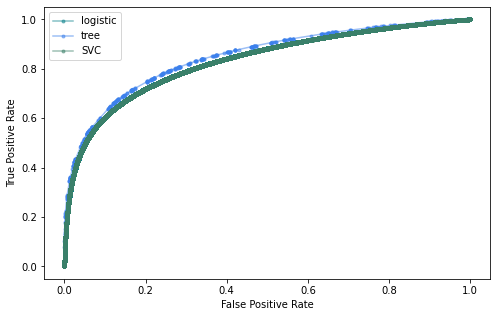

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


------------- LOGISTIC REGRESSION ------------- 



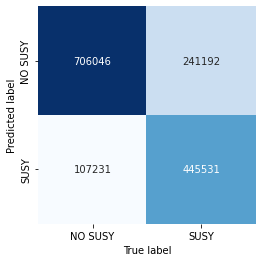

              precision    recall  f1-score   support

     NO SUSY       0.75      0.87      0.80    813277
        SUSY       0.81      0.65      0.72    686723

    accuracy                           0.77   1500000
   macro avg       0.78      0.76      0.76   1500000
weighted avg       0.77      0.77      0.76   1500000

ROC AUC=0.831

 ------------- DECISION TREE ------------- 



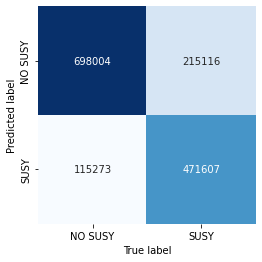

              precision    recall  f1-score   support

     NO SUSY       0.76      0.86      0.81    813277
        SUSY       0.80      0.69      0.74    686723

    accuracy                           0.78   1500000
   macro avg       0.78      0.77      0.77   1500000
weighted avg       0.78      0.78      0.78   1500000

ROC AUC=0.850

 ------------- LINEAR SVC ------------- 



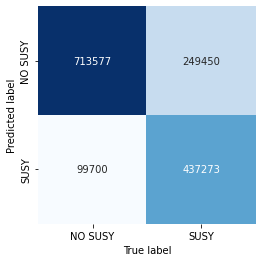

              precision    recall  f1-score   support

     NO SUSY       0.74      0.88      0.80    813277
        SUSY       0.81      0.64      0.71    686723

    accuracy                           0.77   1500000
   macro avg       0.78      0.76      0.76   1500000
weighted avg       0.77      0.77      0.76   1500000

ROC AUC=0.831


In [ ]:
auc_low, estimator_low, y_prob_low, y_test_low = modelClassification('LOW', X_susy_all, y_susy)


In [ ]:
print('El área bajo la curva más grande es de %.3f y corresponde al modelo:' % (auc_low), estimator_low)

El área bajo la curva más grande es de 0.850 y corresponde al modelo: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


### **Características de alto nivel:** 
Son derivadas por los científicos para ayudar a la discriminación de las dos clases.

Best parameters:  {'C': 1.0}
Best parameters:  {'criterion': 'gini', 'max_depth': 9}
Best parameters:  {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}


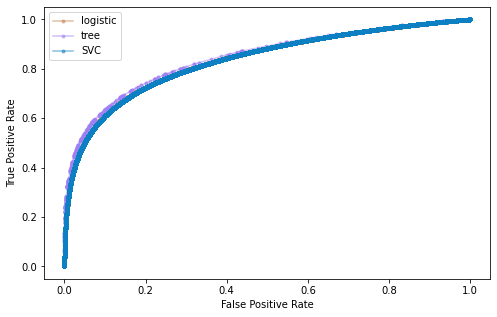

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


------------- LOGISTIC REGRESSION ------------- 



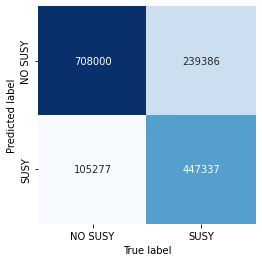

              precision    recall  f1-score   support

     NO SUSY       0.75      0.87      0.80    813277
        SUSY       0.81      0.65      0.72    686723

    accuracy                           0.77   1500000
   macro avg       0.78      0.76      0.76   1500000
weighted avg       0.78      0.77      0.77   1500000

ROC AUC=0.833

 ------------- DECISION TREE ------------- 



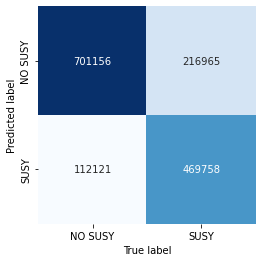

              precision    recall  f1-score   support

     NO SUSY       0.76      0.86      0.81    813277
        SUSY       0.81      0.68      0.74    686723

    accuracy                           0.78   1500000
   macro avg       0.79      0.77      0.78   1500000
weighted avg       0.78      0.78      0.78   1500000

ROC AUC=0.846

 ------------- LINEAR SVC ------------- 



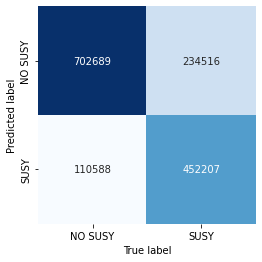

              precision    recall  f1-score   support

     NO SUSY       0.75      0.86      0.80    813277
        SUSY       0.80      0.66      0.72    686723

    accuracy                           0.77   1500000
   macro avg       0.78      0.76      0.76   1500000
weighted avg       0.77      0.77      0.77   1500000

ROC AUC=0.833


In [ ]:
auc_high, estimator_high, y_prob_high, y_test_high = modelClassification('HIGH', X_susy_all, y_susy)

In [ ]:
print('El área bajo la curva más grande es de %.3f y corresponde al modelo:' % (auc_high), estimator_high)

El área bajo la curva más grande es de 0.846 y corresponde al modelo: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


### **High + Low Level**
Ahora, combinando características de bajo y alto nivel:

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Best parameters:  {'C': 0.001}
Best parameters:  {'criterion': 'gini', 'max_depth': 9}
Best parameters:  {'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}


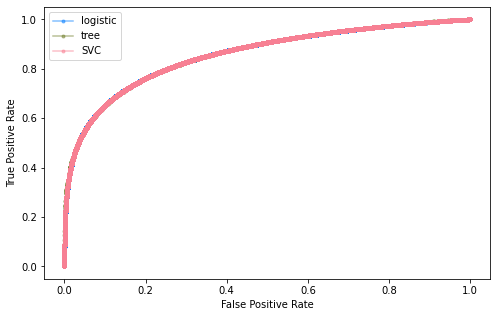

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


------------- LOGISTIC REGRESSION ------------- 



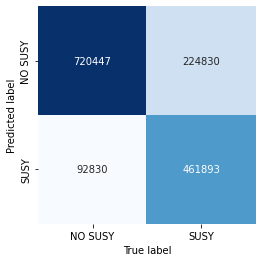

              precision    recall  f1-score   support

     NO SUSY       0.76      0.89      0.82    813277
        SUSY       0.83      0.67      0.74    686723

    accuracy                           0.79   1500000
   macro avg       0.80      0.78      0.78   1500000
weighted avg       0.79      0.79      0.78   1500000

ROC AUC=0.857

 ------------- DECISION TREE ------------- 



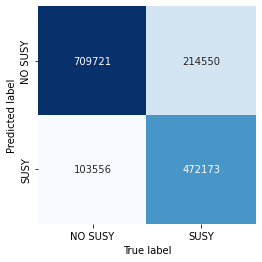

              precision    recall  f1-score   support

     NO SUSY       0.77      0.87      0.82    813277
        SUSY       0.82      0.69      0.75    686723

    accuracy                           0.79   1500000
   macro avg       0.79      0.78      0.78   1500000
weighted avg       0.79      0.79      0.79   1500000

ROC AUC=0.858

 ------------- LINEAR SVC ------------- 



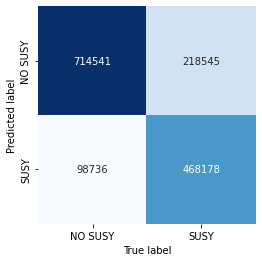

              precision    recall  f1-score   support

     NO SUSY       0.77      0.88      0.82    813277
        SUSY       0.83      0.68      0.75    686723

    accuracy                           0.79   1500000
   macro avg       0.80      0.78      0.78   1500000
weighted avg       0.79      0.79      0.79   1500000

ROC AUC=0.857


In [ ]:
auc_all, estimator_all, y_prob_all, y_test_all= modelClassification('ALL', X_susy_all, y_susy)

In [ ]:
  print('El área bajo la curva más grande es de %.3f y corresponde al modelo:' % (auc_all), estimator_all)

El área bajo la curva más grande es de 0.858 y corresponde al modelo: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


### **Mejores modelos y curva ROC final**

In [ ]:
def bestModels(y_test, y_prob, name):

  # -------- ROC curve --------
  r = random.random()
  b = random.random()
  g = random.random()
  color = (r, 0.3, b)

  # False positives and true positives rate
  fpr, tpr, _ = roc_curve(y_test, y_prob)
  plt.plot(fpr, tpr, marker='.', label=name, color=color)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()

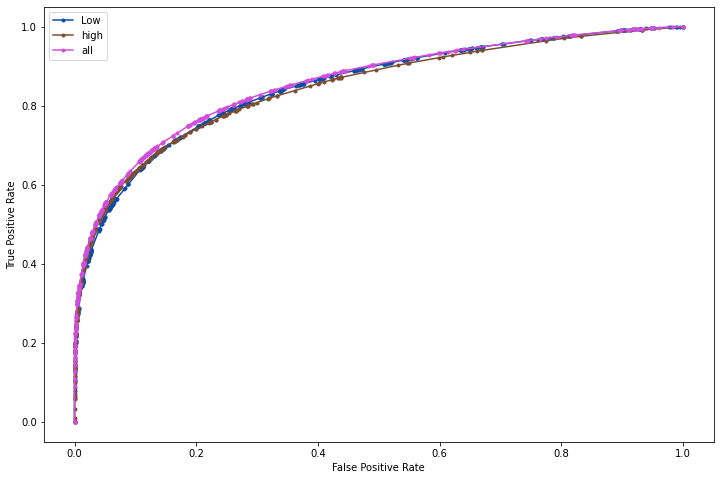

In [ ]:
plt.figure(figsize=(12,8))
bestModels(y_test_low, y_prob_low, 'Low')
bestModels(y_test_high, y_prob_high, 'high')
bestModels(y_test_all, y_prob_all, 'all')
plt.show()

Así como en el artículo "Búsqueda de partículas exóticas en física de altas energías con aprendizaje profundo", el mejor modelo es aquel que tenga un valor mayor de AUC (area under the receiver operating characteristic curve), que indica una mayor precisión de clasificación en una gama de opciones de umbral. 


Respecto a la Figura 7 del artículo (ver abajo): "Rendimiento para el índice de referencia de Higgs", el 'signal efficiency' se define como la fracción de los eventos deseados que realmente obtienen y está relacionado con los 'True Positives' de la figura anterior. Y el término ' background rejection' es la relación `señal/fondo`, es decir, que disminuye a medida que aumenta la tasa de falsos positivos, al contrario de la figura realizada. Sin embargo, la curva ROC es equivalente a la signal efficiency vs. background rejection e igualmente el dataset con mejores predicciones es el que combina las características de alto y bajo nivel.

<img src="figure_7.png">